# Sales Data Analysis


This project uses [Knightbearr's sales product data](https://www.kaggle.com/datasets/knightbearr/sales-product-data) which, though contrived, serves as a useful starting point for store sales data analysis.

## Imports

In [1]:
import pandas as pd

## Getting the data

I downloaded the data archive, which comes with twelve files, each containing data for one of the twelve months of the year. To load the data into a Pandas DataFrame, I used the file name convention to my advantage:

In [2]:
months = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]

df = pd.DataFrame()

for month in months:
    df = pd.concat([df, pd.read_csv("./data/knightbearr-sales-data/Sales_{0}_2019.csv".format(month))], ignore_index = True)

Note that `ignore_index` is set to `True` in the `concat()` call; this is because each DataFrame loaded by the `read_csv()` call in the loop has its own indices and if we don't ignore them, the repetition causes problems with DataFrame concatenation.

As an experiemnt, try to replicate this whole notebook without using the `ignore_index` parameter. You'll see what issues I mean when you get to the grouped monthly sales data.

For now, let's see what sort of data we have:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186850 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 8.6+ MB


The `object`s in the `Dtype` column indicate that all the columns contain strings, which means we'll have to parse the strings in the `Order ID`, `Quantity Ordered`, `Price Each`, and `Order Date` colummns to get numeric values.

First, though, let's see check the data quality.

## Checking data quality

### Missing values

The simplest data qualit check is seeing if there are missing values. Pandas DataFrames have a convenient `innull()` method that returns a DataFrame with the same dimensions as the DataFrame on which it was called, but filled with booleans indicating whether the value at that row and column is null:

In [4]:
df.isnull().sum()

Order ID            545
Product             545
Quantity Ordered    545
Price Each          545
Order Date          545
Purchase Address    545
dtype: int64

Interesing fact: the pandas DataFrame methods `isnull()` and `isna()` are actually the exact same method, according to [this](https://datascience.stackexchange.com/questions/37878/difference-between-isna-and-isnull-in-pandas) Data Science StackExchange answer. The functionality was given two different names for the benefit of R users, because in R a DataFrame can have null as well as NA values, but Python has neither and instead has NaN values!

Looks like 545 entries in each column are null-valued. My bet is that there are 545 rows with all null values, rather than 545 entries in each column being randomly null-valued. The latter is too much coincidence: if there _were_ random nulls in each column, what are the odds the number of nulls in every column would be the same?

Just to satisfy curiosity, let's get the rows with null values and see what we can make of them.

In [5]:
df[df.isnull().any(axis=1)]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
664,NaN,NaN,NaN,NaN,NaN,NaN
678,NaN,NaN,NaN,NaN,NaN,NaN
797,NaN,NaN,NaN,NaN,NaN,NaN
876,NaN,NaN,NaN,NaN,NaN,NaN
1299,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
184678,NaN,NaN,NaN,NaN,NaN,NaN
184695,NaN,NaN,NaN,NaN,NaN,NaN
185042,NaN,NaN,NaN,NaN,NaN,NaN
185729,NaN,NaN,NaN,NaN,NaN,NaN


As expected, there are 545 rows filled with NaNs. What's less expected is that they appear to be randomly distributed, based on a quick glance at the indices. I suppose I expected that they would occur at somewhat regular intervals, e.g. at the end of each of the monthly data files.

Since we know that all the NaN-valued rows are completely useless, we can drop them:

In [6]:
df.dropna(inplace=True)

In [7]:
df.isnull().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

Lovely. Now let's perform some other data quality checks.

### Data type consistency

In [8]:
df.sample(10)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
111224,247410,AAA Batteries (4-pack),1,2.99,08/01/19 10:10,"262 Church St, New York City, NY 10001"
181746,314786,27in 4K Gaming Monitor,1,389.99,12/17/19 09:37,"198 6th St, Boston, MA 02215"
157838,291949,Lightning Charging Cable,1,14.95,11/30/19 23:22,"114 Elm St, Atlanta, GA 30301"
76769,214448,Wired Headphones,2,11.99,06/16/19 08:13,"499 9th St, New York City, NY 10001"
56302,194978,Wired Headphones,1,11.99,05/14/19 15:40,"950 Washington St, Boston, MA 02215"
19361,159707,34in Ultrawide Monitor,1,379.99,02/15/19 15:13,"990 Ridge St, Seattle, WA 98101"
48418,187469,Lightning Charging Cable,1,14.95,04/27/19 19:09,"173 14th St, Los Angeles, CA 90001"
39709,179167,34in Ultrawide Monitor,1,379.99,04/07/19 19:41,"883 Center St, Austin, TX 73301"
153733,288035,Lightning Charging Cable,1,14.95,11/23/19 10:44,"644 Meadow St, Los Angeles, CA 90001"
158126,292229,Bose SoundSport Headphones,1,99.99,11/04/19 18:50,"205 9th St, Austin, TX 73301"


That gives us an idea of what formats each column should be converted to.

Looks like `Order ID` should have one of Python's integer data types. Let's see if any entries don't:

In [9]:
df[df["Order ID"].str.isdecimal() == False].count()

Order ID            355
Product             355
Quantity Ordered    355
Price Each          355
Order Date          355
Purchase Address    355
dtype: int64

Fascinating! Looks like 355 rows contain non-numeric values in every column. Let's check them out.

In [10]:
df[df["Order ID"].str.isdecimal() == False].sample(10)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
100239,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
23866,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
165545,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
185955,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
2463,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
59304,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
51007,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
77376,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
124214,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
174894,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address


I wonder how that might have happened. Then again, this being a contrived dataset, I suppose the important thing is that we are careful to spot these things, rather than why; without knowing how the data was generated, it's almost certain that these rows were programmatically placed in the dataset.

Regardless, let's get rid of them.

In [11]:
df = df[df["Order ID"].str.isdecimal()]
df.sample(10)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
26222,166256,Apple Airpods Headphones,1,150,03/26/19 21:08,"784 Chestnut St, San Francisco, CA 94016"
76507,214199,Bose SoundSport Headphones,1,99.99,06/01/19 22:02,"671 2nd St, Portland, OR 97035"
104149,240664,Flatscreen TV,1,300,08/12/19 11:11,"535 14th St, Boston, MA 02215"
114548,250589,AAA Batteries (4-pack),3,2.99,09/17/19 16:57,"713 9th St, Los Angeles, CA 90001"
6379,147302,AAA Batteries (4-pack),1,2.99,01/21/19 12:16,"335 9th St, Dallas, TX 75001"
27656,167630,AAA Batteries (4-pack),1,2.99,03/08/19 16:25,"305 5th St, Los Angeles, CA 90001"
40840,180254,27in 4K Gaming Monitor,1,389.99,04/16/19 22:04,"309 Center St, Boston, MA 02215"
88155,225341,27in 4K Gaming Monitor,1,389.99,07/13/19 10:10,"780 Center St, New York City, NY 10001"
106754,243145,Apple Airpods Headphones,1,150,08/19/19 13:01,"910 Willow St, Seattle, WA 98101"
3427,144492,20in Monitor,1,109.99,01/13/19 00:37,"11 Cherry St, Seattle, WA 98101"


Now let's run the check again.

In [12]:
df[df["Order ID"].str.isdecimal() == False].count()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

And now the same check with other columns:

In [13]:
df[df["Quantity Ordered"].str.isdecimal() == False].count()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

In [14]:
df[df["Price Each"].str.replace(".", "").str.isnumeric() == False].count()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

Looks good so far. In order to verify that the `Order Date` column contains only date strings, we'll use the `parse` function from the `dateutil.parser` module.

In [15]:
from dateutil.parser import parse

We'll also write a simple function to handle parsing errors by returning `False`, and returning `True` for each successful parse:

In [16]:
def is_date(s):
    try:
        parse(s, fuzzy=True)
        return True
    except:
        return False

Specifying `fuzzy=True` saves us the trouble of going through the data and ensuring all the valid date strings use the same format.

Now we can check the `Order Date` column entries by calling `is_date()`, passing the entry string as the argument `s`:

In [17]:
df[df["Order Date"].map(lambda s: not is_date(s))].count()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

Excellent. Looks like all values are accounted for and everything can be converted to its proper type! We'll do that before running some more data quality checks.

## Data type conversion

In [18]:
try:
    df["Order ID"] = df["Order ID"].astype(int)
    df["Quantity Ordered"] = df["Quantity Ordered"].astype(int)
    df["Price Each"] = df["Price Each"].astype(float)
    df["Order Date"] = pd.to_datetime(df["Order Date"], format="%m/%d/%y %H:%M")
except ValueError:
    print("Couldn't convert a value.")

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185950 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185950 non-null  int32         
 1   Product           185950 non-null  object        
 2   Quantity Ordered  185950 non-null  int32         
 3   Price Each        185950 non-null  float64       
 4   Order Date        185950 non-null  datetime64[ns]
 5   Purchase Address  185950 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(2), object(2)
memory usage: 8.5+ MB


In [20]:
df.sample(10)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
52110,190984,Apple Airpods Headphones,1,150.00,2019-04-06 21:02:00,"827 4th St, Los Angeles, CA 90001"
86097,223364,27in 4K Gaming Monitor,1,389.99,2019-07-26 12:59:00,"13 Cedar St, Los Angeles, CA 90001"
110444,246666,Flatscreen TV,1,300.00,2019-08-03 07:46:00,"226 South St, Atlanta, GA 30301"
154616,288873,AAA Batteries (4-pack),1,2.99,2019-11-25 19:06:00,"205 Spruce St, San Francisco, CA 94016"
27879,167844,Apple Airpods Headphones,1,150.00,2019-03-26 20:37:00,"963 Hill St, Los Angeles, CA 90001"
138203,273211,AAA Batteries (4-pack),1,2.99,2019-10-10 20:00:00,"186 13th St, San Francisco, CA 94016"
83872,221244,AA Batteries (4-pack),2,3.84,2019-06-20 20:22:00,"545 6th St, Austin, TX 73301"
14615,155165,AAA Batteries (4-pack),1,2.99,2019-02-16 14:09:00,"668 Pine St, San Francisco, CA 94016"
104991,241465,Wired Headphones,1,11.99,2019-08-19 15:27:00,"402 Cherry St, New York City, NY 10001"
68290,206379,Wired Headphones,1,11.99,2019-05-25 10:04:00,"57 Madison St, Portland, ME 04101"


Marvelous.

## Data quality checks, continued

Now that we have data in the right format, let's make sure it's _good_ data, using a combination of data visualization and text output.

Note that this will "void the warranty," so to speak, of our data, in the sense that once we've performed these checks, we will have performed so many tests on the data and seen so much of it that we can no longer run traditional hypothesis tests. The reason is simple: suppose we find a correlation or lack of correlation in the data. We know it's there, so running a test on the data for that correlation (or any relationship related to, or dependent on, that correlation) will have a known outcome. Essentially, it wouldn't really be a test, it would just be confirmation of what we already knew was there.

If, on the other hand, we split the data into two parts, say A and B, and run our tests and perform our analyses on just part A, then we can create a script to automate clean up of part B based on our data quality findings. This way, we don't see the data of part B and can use trends found in part A as the basis for _one_ hypothesis test we can run on part B.

We won't be splitting the data in this part of the series, because this part is purely about analysis and not inference. This might make the concept of analysis seem useless, but consider carefully _why_ we can't run hypothesis tests on the data: we would learn too much about it for tests to be valid. We would _learn too much_! That is the biggest, and often overlooked, benefit of good data analysis. It serves to dig deep into the data we have and unearth trends and relationships we'd like to investigate further. It is the basis for constructing bigger statistical systems. After all, what good is statistics, machine learning, or AI, if you have no idea what to use them for? Data analysis tells us where treasure _might_ be, before we buy the big, expensive equipment needed to dig it up.

Hopefully that provides some reasonable motivation to perform analyses prior to investing in more rigorous or expensive information processing pipelines.

Let's continue. First, let's use the `pandas.DataFrame.describe()` method to get a quick overview of the data.

### General information

In [21]:
df.describe()

,Order ID,Quantity Ordered,Price Each,Order Date
count,185950.000000,185950.000000,185950.000000,185950
mean,230417.569379,1.124383,184.399735,2019-07-18 21:54:38.887550208
min,141234.000000,1.000000,2.990000,2019-01-01 03:07:00
25%,185831.250000,1.000000,11.950000,2019-04-16 21:05:15
50%,230367.500000,1.000000,14.950000,2019-07-17 20:40:30
75%,275035.750000,1.000000,150.000000,2019-10-26 08:14:00
max,319670.000000,9.000000,1700.000000,2020-01-01 05:13:00
std,51512.737110,0.442793,332.731330,NaN


Here are a few observations we can make based on just this:
1. The maximum `Quantity Ordered` is 9, yet the 75th percentile is 1; this means that more than one of an items is ordered less than 25% of the time. This is further supported by the standard deviation of `Quantity Ordered` being only ~0.44.
2. The most expensive item in the store costs \\$1,700.
3. There is an order on the first of January, 2020 &mdash; we should get rid of that data point (as well as any others that do not take place in 2019) to confine ourselves purely to 2019 data.
4. Order dates are pretty evenly distributed: the minimum is January 1, the first quartile is mid April, the median is late-mid July, the third quartile is late October, and the maximum, is the first day of the new year.

Now let's perform some simple visual analyses on each numeric column's distribution, and see what we can learn.

### Data distributions

array([[<Axes: title={'center': 'Quantity Ordered'}>,
        <Axes: title={'center': 'Price Each'}>],
       [<Axes: title={'center': 'Order Date'}>, <Axes: >]], dtype=object)

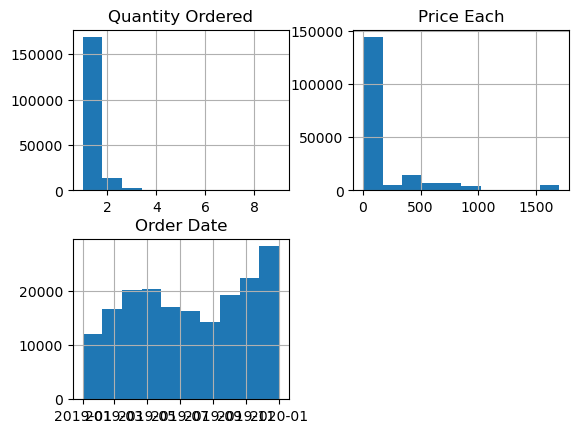

In [22]:
df[["Quantity Ordered", "Price Each", "Order Date"]].hist()

Rough, but informative.

The distribution of the values in the `Quantity Ordered` column confirms our earlier inference that most orders contain a single item. The histogram additionally tells us that hardly any orders contain more than three of any item.

The `Order Date` distribution tells us how busy the store was during various times of the year. That end-of-year peak could mean that the store's sales are on the rise year-over-year, but I suspect it's more likely to be explained by the fact that December incentives shopping, due to Christmas, Boxing Day, and the New Year. We would need to see data for January and a bit later of 2020 to be certain.

The `Price Each` histogram is particularly interesting. Inexpensive items comprise the vast majority of orders, which makes sense, but there is an out-of-place bump in sales of items costing more than \\$1,500. Why? Let's see what items have a price greater than \\$1,500 and see if we can infer the reason.

In [23]:
df.loc[df["Price Each"] > 1500].sample(10)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
13154,153772,Macbook Pro Laptop,1,1700.0,2019-02-06 00:03:00,"104 Meadow St, San Francisco, CA 94016"
90055,227148,Macbook Pro Laptop,1,1700.0,2019-07-01 08:11:00,"161 Ridge St, Boston, MA 02215"
181501,314556,Macbook Pro Laptop,1,1700.0,2019-12-02 08:16:00,"709 1st St, Portland, ME 04101"
87664,224870,Macbook Pro Laptop,1,1700.0,2019-07-22 17:04:00,"74 Church St, Los Angeles, CA 90001"
91643,228667,Macbook Pro Laptop,1,1700.0,2019-07-30 22:50:00,"940 Cherry St, Boston, MA 02215"
174278,307639,Macbook Pro Laptop,1,1700.0,2019-12-05 09:27:00,"133 7th St, San Francisco, CA 94016"
103203,239749,Macbook Pro Laptop,1,1700.0,2019-08-05 15:08:00,"671 1st St, San Francisco, CA 94016"
3157,144232,Macbook Pro Laptop,1,1700.0,2019-01-09 14:34:00,"439 Forest St, San Francisco, CA 94016"
110449,246671,Macbook Pro Laptop,1,1700.0,2019-08-23 11:13:00,"457 Cedar St, Dallas, TX 75001"
79085,216667,Macbook Pro Laptop,1,1700.0,2019-06-18 09:53:00,"538 12th St, Los Angeles, CA 90001"


That makes sense, the Macbook Pro is an extremely popular personal computer.

Occasionally, datasets will collect all values beyond a cutoff point into the same maximum value. For instance, a real estate dataset may have a price cutoff of \\$1,000,000, and any properies with values exceeding that will be counted as having a price of \\$1,000,000, resulting in a bump on the right edge of the price histogram. I'm glad to see that's not what happened here.

Everything checks out in terms of data quality, so let's move on to data transformation!

## Data transformation

Remember that we got rid of several rows earlier, because they contained null values or contained the column names rather than any useful information; that messed up our index, because now there are "holes" in it. It's possibly not a big deal, but I prefer to have all the useful data logically sorted and indexed. So let's sort and reindex our DataFrame.

In [24]:
df.sort_values(by = "Order ID", inplace = True)
df.reset_index(drop = True, inplace = True)

Next, remember that we discovered earlier that the maximum `Order Date` is January 1, 2020. Since this is an analysis of 2019 data, we don't want any 2020 orders, so let's get rid of those rows. But first, I'm curious to see how many 2020 orders made it into this data set.

In [25]:
df.loc[df["Order Date"] >= parse("01/01/2020")]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
162516,297150,Lightning Charging Cable,1,14.95,2020-01-01 00:38:00,"427 Wilson St, Dallas, TX 75001"
163216,297817,iPhone,1,700.00,2020-01-01 00:22:00,"519 13th St, New York City, NY 10001"
163217,297817,Lightning Charging Cable,2,14.95,2020-01-01 00:22:00,"519 13th St, New York City, NY 10001"
163376,297969,Google Phone,1,600.00,2020-01-01 00:54:00,"542 2nd St, San Francisco, CA 94016"
163757,298344,Wired Headphones,4,11.99,2020-01-01 03:34:00,"731 7th St, New York City, NY 10001"
164498,299049,Apple Airpods Headphones,1,150.00,2020-01-01 01:17:00,"762 Johnson St, San Francisco, CA 94016"
164578,299125,USB-C Charging Cable,1,11.95,2020-01-01 04:21:00,"754 Hickory St, New York City, NY 10001"
165875,300362,USB-C Charging Cable,1,11.95,2020-01-01 00:59:00,"581 River St, San Francisco, CA 94016"
166037,300519,Bose SoundSport Headphones,1,99.99,2020-01-01 05:13:00,"657 Spruce St, New York City, NY 10001"
166038,300519,Lightning Charging Cable,1,14.95,2020-01-01 05:13:00,"657 Spruce St, New York City, NY 10001"


Not many when compared to the size of the dataset, but a lot more than I expected. Instead of just discarding it, let's put this stuff into a new DataFrame, separate from our 2019 data. We'll also put the 2019 data into its own DataFrame. This ensures we have the original data, should we ever want to refer to it.

In [26]:
data_2020 = df.loc[df["Order Date"] >= parse("01/01/2020")].copy()
data_2019 = df.loc[df["Order Date"] < parse("01/01/2020")].copy()

In [27]:
data_2019.describe()

,Order ID,Quantity Ordered,Price Each,Order Date
count,185916.000000,185916.000000,185916.000000,185916
mean,230403.546526,1.124368,184.387720,2019-07-18 21:10:53.291163392
min,141234.000000,1.000000,2.990000,2019-01-01 03:07:00
25%,185822.750000,1.000000,11.950000,2019-04-16 20:52:00
50%,230351.500000,1.000000,14.950000,2019-07-17 20:09:30
75%,275015.250000,1.000000,150.000000,2019-10-26 06:58:00
max,319670.000000,9.000000,1700.000000,2019-12-31 23:53:00
std,51506.924899,0.442749,332.722426,NaN


In [28]:
data_2020.describe()

,Order ID,Quantity Ordered,Price Each,Order Date
count,34.000000,34.000000,34.000000,34
mean,307096.176471,1.205882,250.100000,2020-01-01 01:59:08.823529472
min,297150.000000,1.000000,2.990000,2020-01-01 00:10:00
25%,300519.000000,1.000000,14.950000,2020-01-01 00:46:30
50%,306868.500000,1.000000,109.990000,2020-01-01 01:46:00
75%,312612.000000,1.000000,262.500000,2020-01-01 03:09:15
max,319366.000000,4.000000,1700.000000,2020-01-01 05:13:00
std,6959.955266,0.640994,378.149071,NaN


Excellent. Now we can save the datasets in Excel spreadsheet format to make them easier to work with for others, and  move on to analysis.

In [29]:
import openpyxl

In [30]:
data_2019.to_excel("data_2019.xlsx", index=False)
data_2020.to_excel("data_2020.xlsx", index=False)

## Data analysis

A good rule of thumb in data analysis, especially in _exploratory_ data analysis, when we don't have a specific question we're interested in, is to get a big picture overview of general information and then get progressively more specific as questions arise.

Since we're analyzing store data, let's start by checking out the year's sales statistics.

### Total sales in 2019

Since the data records each type item sold at a time as its own order, the year's total sales will be equal to each order's `Quantity Ordered` multiplied by the item's `Price Each`.

In [31]:
total_sales = (data_2019["Quantity Ordered"] * data_2019["Price Each"]).sum()
total_sales

34483365.67999999

So, in 2019, the store had a revenue of around \\$3,448,365.68. Not bad, though without knowing where the store is geographically, how many employees it has, and what its costs are, there's no way to tell whether that's objectively good. In a very high cost of living area, with many employees, and high costs, each employee and store owner may not have lavish lifestyles. On the other hand, if it's in a low cost of living area, with only a few employees, and not much cash outflow, the store's employees could be living like royalty.

Let's get a bit more specific, and examine the monthly statistics.

### Monthly statistics


The `Order Date` histogram we created previously in the data quality check section gave us an overview of how orders are distributed by month, but we don't know if sales (i.e. revenue) follow the same distribution. Let's find out!

If we're going to be splitting data up based on unique values of a categorical variable, though, it's convenient to have a column containing specifically the values of that variable. Currently, the month of each order is tied up in its `Order Date`, and we'd have to parse each entry individually to extract the order's month. That's both computationally expensive and a messy thing to code. So let's create new colummns for the number and name of the month of each order (e.g. April is number 4), as well as separate columns for the day of the month, day of the year (e.g. February 1 is the 32nd day of the year), and weekday (Sunday, Monday, etc.). This will let us investigate such things as whether sales spike on December 24th, see sales as a per-day time series spanning the duration of 2019, and how the day of the week impacts sales.

We will need to import the `datetime.datetime` module first.

#### Further data transformation

In [32]:
from datetime import datetime

In [33]:
data_2019.loc[:, "Date"] = pd.Series(data_2019.loc[:, "Order Date"].map(lambda d: d.date()))
data_2019.loc[:, "Time"] = pd.Series(data_2019.loc[:, "Order Date"].map(lambda d: d.time()))
data_2019.loc[:, "Month Number"] = pd.Series(data_2019.loc[:, "Order Date"].map(lambda d: d.month)).astype("Int8")
data_2019.loc[:, "Month Name"] = pd.Series(data_2019.loc[:, "Order Date"].map(lambda d: d.month_name()))
data_2019.loc[:, "Day"] = pd.Series(data_2019.loc[:, "Order Date"].map(lambda d: d.day)).astype("Int8")
data_2019.loc[:, "Weekday"] = pd.Series(data_2019.loc[:, "Order Date"].map(lambda d: d.day_name()))

In [34]:
data_2019.sort_values("Order Date").head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Date,Time,Month Number,Month Name,Day,Weekday
6317,147268,Wired Headphones,1,11.99,2019-01-01 03:07:00,"9 Lake St, New York City, NY 10001",2019-01-01,03:07:00,1,January,1,Tuesday
7124,148041,USB-C Charging Cable,1,11.95,2019-01-01 03:40:00,"760 Church St, San Francisco, CA 94016",2019-01-01,03:40:00,1,January,1,Tuesday
8471,149343,Apple Airpods Headphones,1,150.00,2019-01-01 04:56:00,"735 5th St, New York City, NY 10001",2019-01-01,04:56:00,1,January,1,Tuesday
9122,149964,AAA Batteries (4-pack),1,2.99,2019-01-01 05:53:00,"75 Jackson St, Dallas, TX 75001",2019-01-01,05:53:00,1,January,1,Tuesday
8478,149350,USB-C Charging Cable,2,11.95,2019-01-01 06:03:00,"943 2nd St, Atlanta, GA 30301",2019-01-01,06:03:00,1,January,1,Tuesday


In [35]:
data_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185916 entries, 0 to 185949
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185916 non-null  int32         
 1   Product           185916 non-null  object        
 2   Quantity Ordered  185916 non-null  int32         
 3   Price Each        185916 non-null  float64       
 4   Order Date        185916 non-null  datetime64[ns]
 5   Purchase Address  185916 non-null  object        
 6   Date              185916 non-null  object        
 7   Time              185916 non-null  object        
 8   Month Number      185916 non-null  Int8          
 9   Month Name        185916 non-null  object        
 10  Day               185916 non-null  Int8          
 11  Weekday           185916 non-null  object        
dtypes: Int8(2), datetime64[ns](1), float64(1), int32(2), object(6)
memory usage: 14.9+ MB


In [36]:
data_2019.describe()

,Order ID,Quantity Ordered,Price Each,Order Date,Month Number,Day
count,185916.000000,185916.000000,185916.000000,185916,185916.0,185916.0
mean,230403.546526,1.124368,184.387720,2019-07-18 21:10:53.291163392,7.060248,15.762231
min,141234.000000,1.000000,2.990000,2019-01-01 03:07:00,1.0,1.0
25%,185822.750000,1.000000,11.950000,2019-04-16 20:52:00,4.0,8.0
50%,230351.500000,1.000000,14.950000,2019-07-17 20:09:30,7.0,16.0
75%,275015.250000,1.000000,150.000000,2019-10-26 06:58:00,10.0,23.0
max,319670.000000,9.000000,1700.000000,2019-12-31 23:53:00,12.0,31.0
std,51506.924899,0.442749,332.722426,NaN,3.502358,8.780711


Perfect. Now, let's analyze.

#### Total monthly sales

<Axes: xlabel='Month Number'>

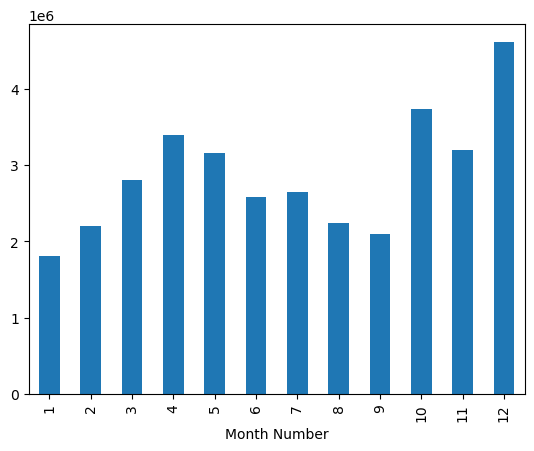

In [37]:
total_monthly_sales = (data_2019["Quantity Ordered"] * data_2019["Price Each"]).groupby(data_2019["Month Number"]).sum()
total_monthly_sales.plot(kind="bar")

For comparison, here's the twelve-bin histogram of `Order Date`s:

<Axes: >

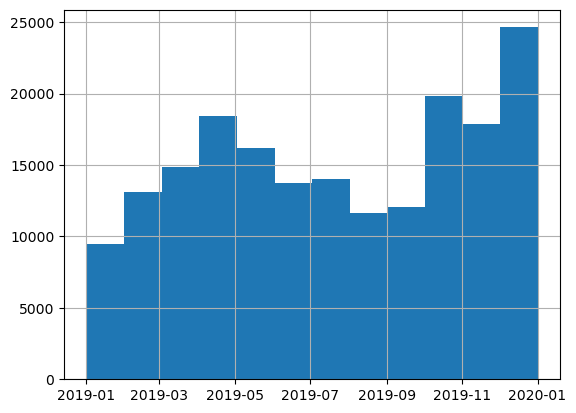

In [38]:
data_2019["Order Date"].hist(bins=12)

The distribution of total monthly sales follows the approximate distribution of orders per month. No surprises there. This means that there aren't any major shifts in the percentage of orders per month that each item makes up.

For example, suppose that in April, almost all orders were of expensive electronics like the Macbook Pro or the iPhone; in that case, the bar representing monthly sales in April would be significantly taller than it is, and the distribution would have a pretty glaring difference when compared to the orders-per-month distribution.

#### Average monthly sales

<Axes: xlabel='Month Number'>

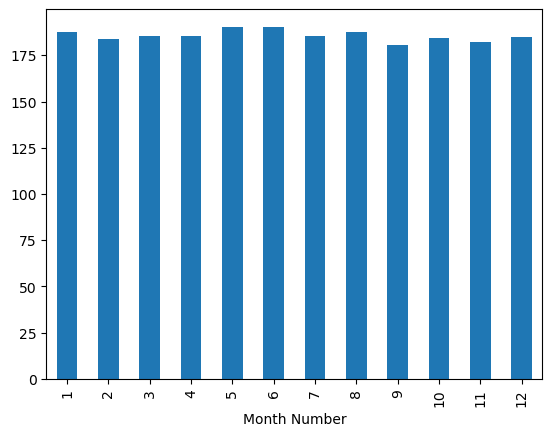

In [39]:
average_monthly_sales = (data_2019["Quantity Ordered"] * data_2019["Price Each"]).groupby(data_2019["Month Number"]).mean()
average_monthly_sales.plot(kind="bar")

Hardly any variation in the average sales per month. Interesting. I would've thought that there would be a significant spike in August and September, thinking that a somewhat larger portion of sales would comprise new phones and laptops due to academic institutions starting a new year, and in December, due to the same change in portion but caused by Christmas and the new year.

Maybe the monthly orders are different?

#### Total monthly orders

<Axes: xlabel='Month Number'>

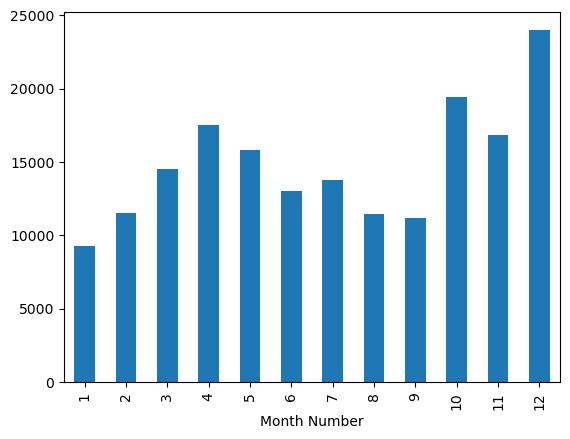

In [40]:
total_monthly_orders = data_2019.groupby(data_2019["Month Number"])["Order ID"].nunique()
total_monthly_orders.plot(kind="bar")

Nothing unexpected here either. Of course, if the distribution of the number of orders per month resembles the distribution of total sales per month, it's practically guaranteed that the distribution of the average price per order per month is going to be more or less a horizontal line, i.e. constant. Let's verify that, though.

#### Average spent per order per month

<Axes: xlabel='Month Number'>

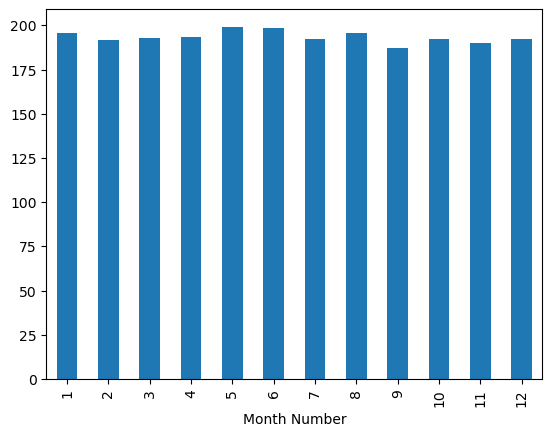

In [41]:
avg_monthly_order_price = total_monthly_sales / total_monthly_orders
avg_monthly_order_price.plot(kind="bar")

Approximately constant, as expected. In fact, let's be _really_ sure. Let's add a regression line to this bar plot.

We will need `numpy` and `matplotlib`.

In [42]:
import numpy as np
import matplotlib.pyplot as plt

By the way, in addition to the official documentation, I also recommend [this](https://realpython.com/python-matplotlib-guide/) excellent guide on the Real Python website, written by Brad Solomon, for a high-level understanding of Matplotlib.

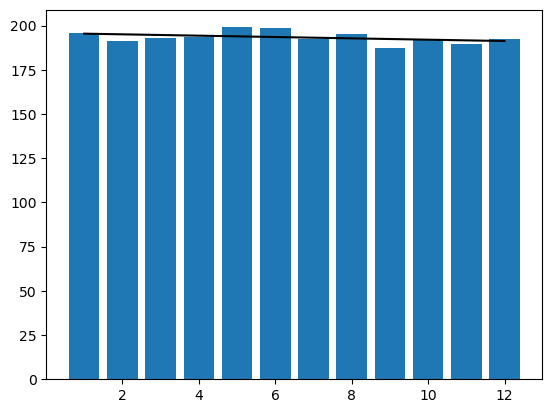

In [43]:
x = avg_monthly_order_price.index.to_list()
y = avg_monthly_order_price.values

fig, ax = plt.subplots()

ax.bar(x, y)

params = np.polyfit(x, y, 1)
curve = np.poly1d(params)

ax.plot(x, curve(x), "black")

plt.show()

That the regression line is almost perfectly horizontal, indicating almost no change in the monthly average spending per order.
We can see the exact parameters of the line, too:

In [44]:
params

array([ -0.37872812, 195.84685675])

The line has a slope of around -0.4 and a y-intercept of around 196.

I think that's the most we can really do with the monthly timeframe. The thing with months is that they're just long enough that the weather can change noticeably in between them, and only a few months exist between major social and economic events like the resuming of academics in September, Halloween in October, Christmas in December, Valentine's Day in February, spring break, summer vacation, etc. All of these things can affect purchases pretty significantly, so without being able to compare data for the same season over multiple years, monthly data turns out not to be terribly useful.

### Daily statistics

Daily statistics are found in the same way as monthly statistics.

#### Daily time series

Time series are useful because they show how a variable changes with respect to a fixed time increment. Let's plot a time series of daily sales.

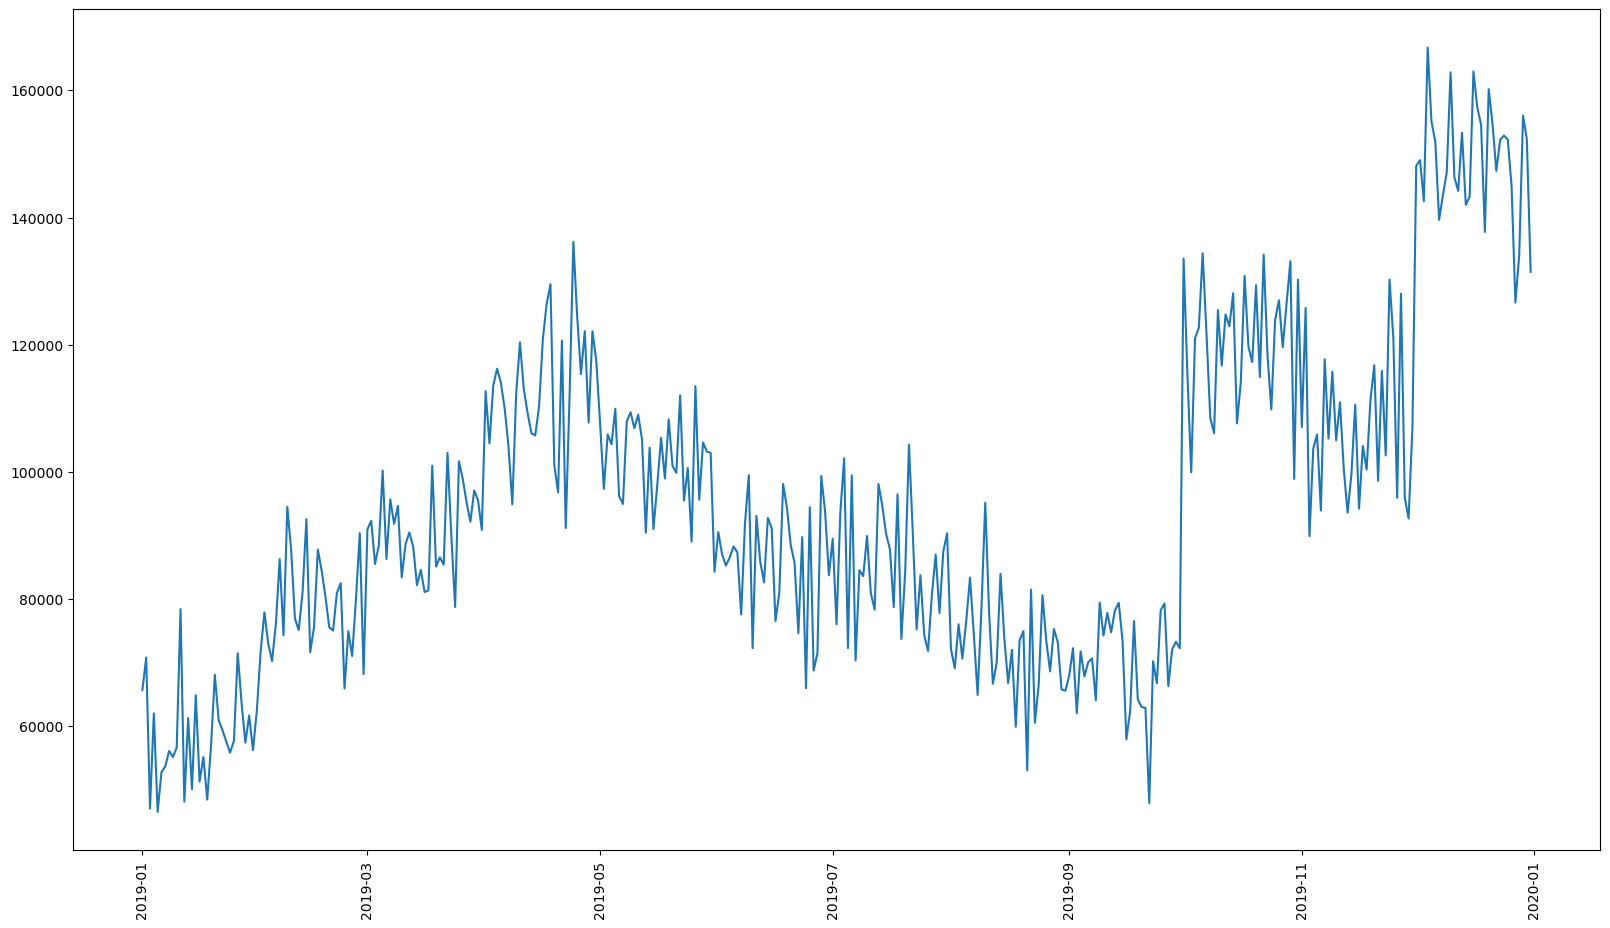

In [45]:
total_daily_sales = (data_2019["Quantity Ordered"] * data_2019["Price Each"]).groupby(data_2019["Date"]).sum()

x = total_daily_sales.index.to_list()
y = total_daily_sales

fig, ax = plt.subplots(figsize=(16, 9))
fig.tight_layout()

ax.plot(x, y)
ax.tick_params(axis="x", labelrotation=90)

plt.show()

Those spikes in late September/early October and late November/early December are interesting. Let's examine them further.

<Axes: xlabel='Date'>

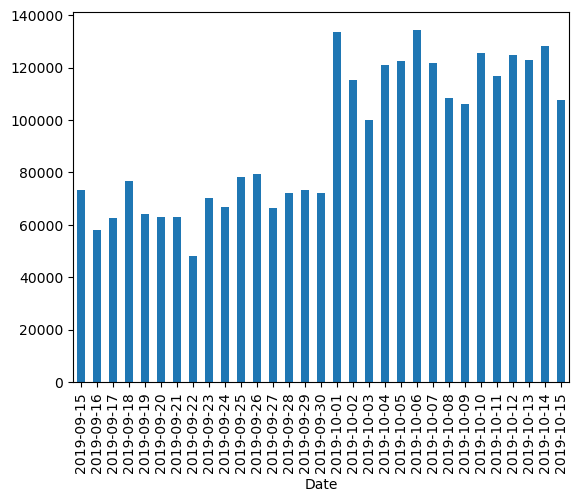

In [46]:
total_daily_sales[datetime.strptime("2019-09-15", "%Y-%m-%d").date():datetime.strptime("2019-10-15", "%Y-%m-%d").date()].plot(kind="bar")

I checked various US 2019 calendars, and found no holiday that could explain the sudden jump. I do know that Halloween is an extremely popular day, and people often get excited for it and begin preparations quite early. Maybe that excitement for Halloween and Fall could explain this spike? Data for more years would be needed to see if this is an anomaly or a regular occurence.

<Axes: xlabel='Date'>

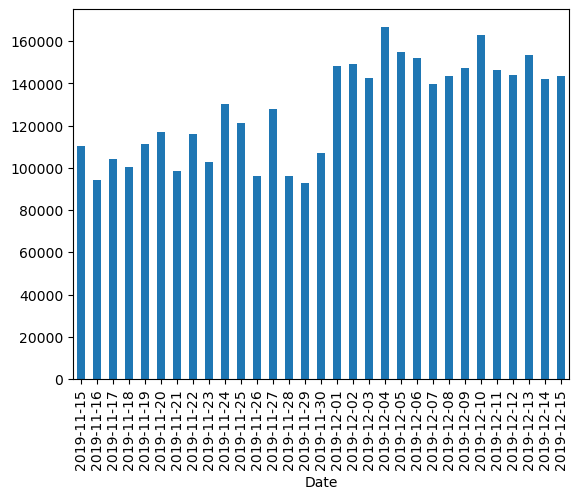

In [47]:
total_daily_sales[datetime.strptime("2019-11-15", "%Y-%m-%d").date():datetime.strptime("2019-12-15", "%Y-%m-%d").date()].plot(kind="bar")

It appears the second spike occurs over two days, a small jump on November 30 and a bigger jump on December 1. [This](https://www.calendar-365.com/holidays/2019.html) calendar says that November 29, 2019 was Black Friday, and December 2 was Cyber Monday. That, combined with early Christmas shoppers, may explain this second spike. It would be interesting to see data for more years and see if the same spike exists in those data.

#### Weekday analysis

Let's see what day of the week has the most sales.

<Axes: xlabel='Weekday'>

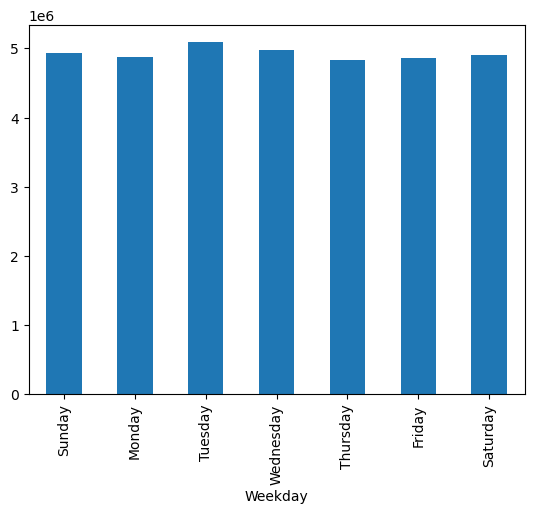

In [48]:
total_weekday_sales = (data_2019["Quantity Ordered"] * data_2019["Price Each"]).groupby(data_2019["Weekday"]).sum()
total_weekday_sales = total_weekday_sales.reindex(["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
total_weekday_sales.plot(kind="bar")

Doesn't appear to be much variation. This is data from an online store, so I guess the typical Friday/weekend rush is reduced and there's a more spread-out orders-per-day frequency.

Let's move on.

### Demographics

Where do most sales come from? Are people from certain areas more likely to purchase certain things? This is the interesting stuff!

Let's start by analyzing the distribution of total sales by state. To do that, we'll create new columns for each order's customer's state, and also their city and zip code, just in case.

#### Further data transformation

In [49]:
data_2019.loc[:, "State"] = pd.Series(data_2019.loc[:, "Purchase Address"].map(lambda s: s.split(",")[2].strip()[0:2]))
data_2019.loc[:, "City"] = pd.Series(data_2019.loc[:, "Purchase Address"].map(lambda s: s.split(",")[1].strip()))
data_2019.loc[:, "Zip Code"] = pd.Series(data_2019.loc[:, "Purchase Address"].map(lambda s: s.split(",")[2].strip()[3:]))

data_2019

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Date,Time,Month Number,Month Name,Day,Weekday,State,City,Zip Code
0,141234,iPhone,1,700.00,2019-01-22 21:25:00,"944 Walnut St, Boston, MA 02215",2019-01-22,21:25:00,1,January,22,Tuesday,MA,Boston,02215
1,141235,Lightning Charging Cable,1,14.95,2019-01-28 14:15:00,"185 Maple St, Portland, OR 97035",2019-01-28,14:15:00,1,January,28,Monday,OR,Portland,97035
2,141236,Wired Headphones,2,11.99,2019-01-17 13:33:00,"538 Adams St, San Francisco, CA 94016",2019-01-17,13:33:00,1,January,17,Thursday,CA,San Francisco,94016
3,141237,27in FHD Monitor,1,149.99,2019-01-05 20:33:00,"738 10th St, Los Angeles, CA 90001",2019-01-05,20:33:00,1,January,5,Saturday,CA,Los Angeles,90001
4,141238,Wired Headphones,1,11.99,2019-01-25 11:59:00,"387 10th St, Austin, TX 73301",2019-01-25,11:59:00,1,January,25,Friday,TX,Austin,73301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185945,319666,Lightning Charging Cable,1,14.95,2019-12-11 20:58:00,"14 Madison St, San Francisco, CA 94016",2019-12-11,20:58:00,12,December,11,Wednesday,CA,San Francisco,94016
185946,319667,AA Batteries (4-pack),2,3.84,2019-12-01 12:01:00,"549 Willow St, Los Angeles, CA 90001",2019-12-01,12:01:00,12,December,1,Sunday,CA,Los Angeles,90001
185947,319668,Vareebadd Phone,1,400.00,2019-12-09 06:43:00,"273 Wilson St, Seattle, WA 98101",2019-12-09,06:43:00,12,December,9,Monday,WA,Seattle,98101
185948,319669,Wired Headphones,1,11.99,2019-12-03 10:39:00,"778 River St, Dallas, TX 75001",2019-12-03,10:39:00,12,December,3,Tuesday,TX,Dallas,75001


Lovely. Now we can analyze.

#### What states do orders come from?

<Axes: xlabel='State'>

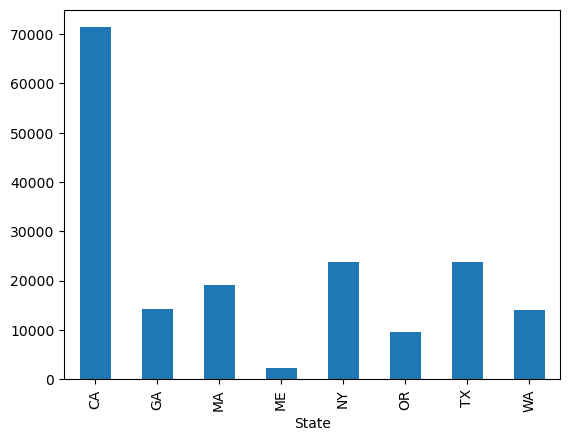

In [50]:
state_orders = data_2019.groupby("State")["Order ID"].nunique()
state_orders.plot(kind="bar")

In [51]:
state_orders.sort_values(ascending = False)

State
CA    71384
NY    23840
TX    23745
MA    19088
GA    14253
WA    14118
OR     9615
ME     2363
Name: Order ID, dtype: int64

Looks like the states from which orders are made are, in descending order of number of orders, California, New York, Texas, Massachusetts, Georgia, Washington, Oregon, and Maine, with California ordering more than New York, Texas, and Massachusetts put together.

But do more orders necessarily translate into more revenue from each state? Let's see.

#### Sales by state

<Axes: xlabel='State'>

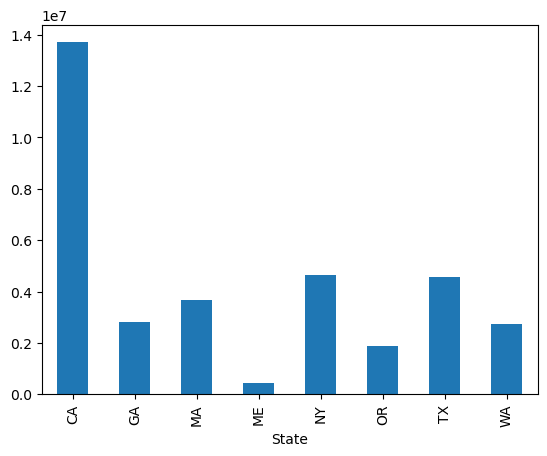

In [52]:
state_sales = (data_2019["Quantity Ordered"] * data_2019["Price Each"]).groupby(data_2019["State"]).sum()
state_sales.plot(kind="bar")

In [53]:
state_sales.sort_values(ascending = False)

State
CA    13711289.84
NY     4662976.81
TX     4585342.22
MA     3660315.12
GA     2795498.58
WA     2747605.49
OR     1870579.35
ME      449758.27
dtype: float64

Looks like there is indeed a _very_ strong correlation between the number of orders and revenue from each state. Which makes sense, though, truth be told, I was hoping for something unexpected.

Maybe there's something to see in the per-city data?

#### Orders and revenue by city

This time, let's skip the prose and get fancy with the code.

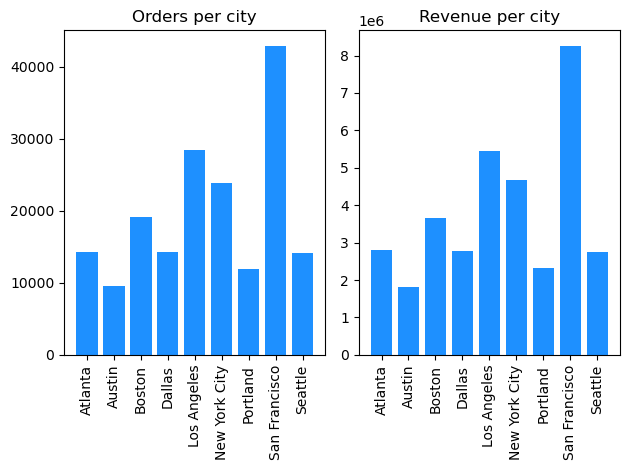

In [54]:
city_orders = data_2019.groupby("City")["Order ID"].nunique()
city_sales = (data_2019["Quantity Ordered"] * data_2019["Price Each"]).groupby(data_2019["City"]).sum().reindex(city_orders.index)

x = city_orders.index.to_list()
y1 = city_orders
y2 = city_sales

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.bar(x, y1, color="dodgerblue")
ax2.bar(x, y2, color="dodgerblue")

ax1.set_title("Orders per city")
ax2.set_title("Revenue per city")

ax1.tick_params(axis="x", labelrotation=90)
ax2.tick_params(axis="x", labelrotation=90)

fig.tight_layout()

plt.show()

Identical. The final topic to analyze is the products themselves.

### Product analysis

This section will be a sort of aggregate of exploration. We'll get the prices of all the products, examine how many orders each product has, and see how much each product contributed to yearly revenue in 2019.

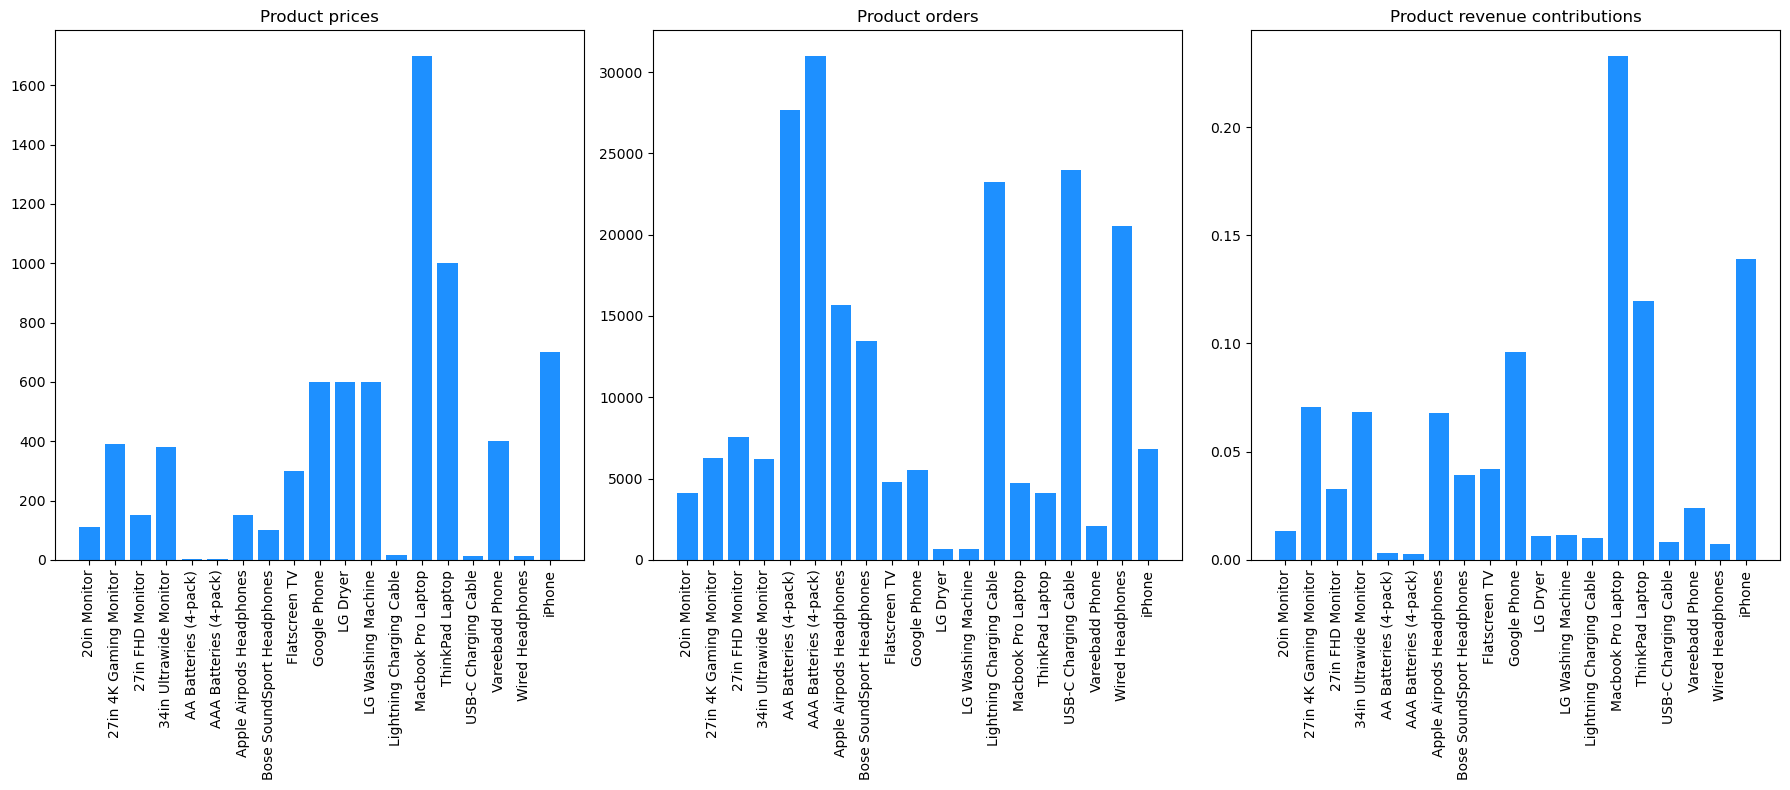

In [55]:
product_prices = data_2019["Price Each"].groupby(data_2019["Product"]).mean()
product_orders = data_2019["Quantity Ordered"].groupby(data_2019["Product"]).sum().reindex(product_prices.index)
product_sales_contributions = (data_2019["Quantity Ordered"] * data_2019["Price Each"]).groupby(data_2019["Product"]).sum().reindex(product_prices.index) / total_sales  # We found total_sales near the beginning of this notebook

y1 = product_prices
y2 = product_orders
y3 = product_sales_contributions
x = product_prices.index.to_list()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))

ax1.bar(x, y1, color="dodgerblue")
ax2.bar(x, y2, color="dodgerblue")
ax3.bar(x, y3, color="dodgerblue")

ax1.set_title("Product prices")
ax2.set_title("Product orders")
ax3.set_title("Product revenue contributions")

ax1.tick_params(axis="x", labelrotation=90)
ax2.tick_params(axis="x", labelrotation=90)
ax3.tick_params(axis="x", labelrotation=90)

fig.tight_layout()

plt.show()

Unsurprisingly, the least expensive items sell the most, and vice versa.

What is most interesting is the product sales contribution chart in the context of the other two. Here are some observations:
1. The batteries, charging cables, and wired headphones, which are very inexpensive and sold the most, contributed hardly anything to the yearly revenue.
2. On the other hand, the Macbook Pro, iPhone, and ThinkPad laptop, which are the three most expensive and least ordered products, contributed the most to yearly revenue.
3. The appliances are mid-range in terms of price but sold so few units that their combined contribution to yearly revenue was less than 3%.
4. The 20in monitor is cheap, sold a meager number of units, and had a yearly revenue contribution of less than 2%.
5. The Vareebadd phone (yes, yes &mdash; remember this isn't real world data, most store owners are hesitant to have their yearly numbers be known so we make do with what we have) isn't terribly expensive, but sold very few units and had a yearly revenue contribution of around 2.5%.

Based on this, we can make a few recommendations:
1. Get rid of the appliances and focus exclusively on small electronics and their accessories.
2. Get rid of the 20in monitor and Vareebadd phone and focus exclusively on brand name, high quality products.
3. Things like batteries, charging cables, and wired headphones, though contributing very little to yearly revenue, are probably cheap enough to order in bulk and keep in stock, so maybe those things can be shown in a "Recommended" items section when the customer goes to checkout their order?

Next, I want to plot the proportion of orders each product constitutes per month, as well as per state.

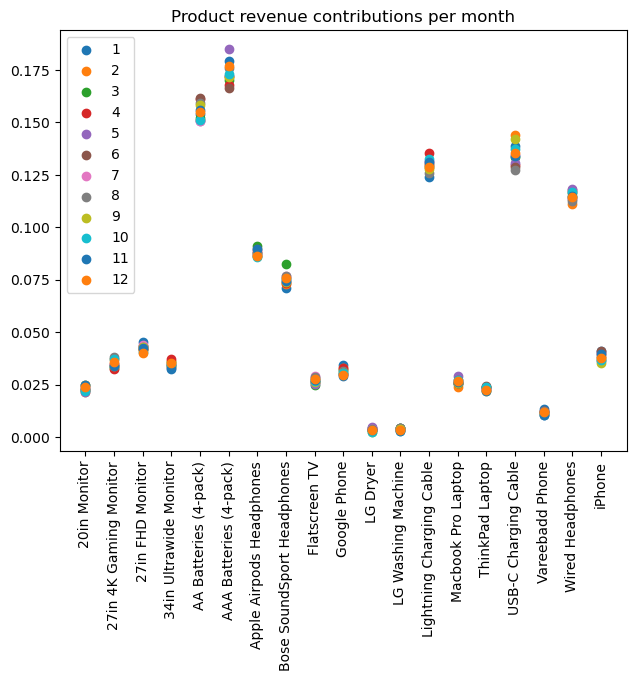

In [56]:
product_order_proportions_per_month = data_2019.groupby(["Month Number", "Product"])["Quantity Ordered"].sum()

month_numbers = product_order_proportions_per_month.index.levels[0].to_list()
x = product_order_proportions_per_month.index.levels[1]

fig, ax = plt.subplots()
fig.tight_layout()

for month in month_numbers:
    ax.scatter(x, product_order_proportions_per_month.loc[[month]] / total_monthly_orders[month])

ax.set_title("Product revenue contributions per month")
ax.tick_params(axis="x", labelrotation=90)
ax.legend(month_numbers)

Doesn't look like there's much variation between months, though it seems there was a slightly higher-than-normal demand for AAA batteries in May. Let's see the per-state plots.

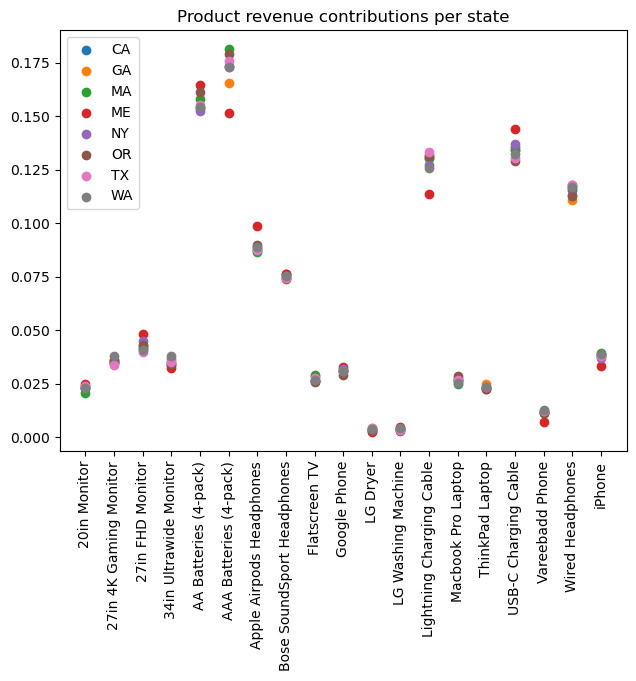

In [57]:
product_order_proportions_per_state = data_2019.groupby(["State", "Product"])["Quantity Ordered"].sum()

states = product_order_proportions_per_state.index.levels[0].to_list()
x = product_order_proportions_per_state.index.levels[1]

fig, ax = plt.subplots()
fig.tight_layout()

for state in range(len(states)):
    ax.scatter(x, product_order_proportions_per_state.loc[[states[state]]] / state_orders.reindex(product_order_proportions_per_state.index.levels[0])[state])

ax.set_title("Product revenue contributions per state")
ax.tick_params(axis="x", labelrotation=90)
ax.legend(states)

Maine is at an extreme in most product revenue contributions. Why do they need so many USB-C cables and Apple Airpods, yet so few AAA batteries and lightning cables? What's going on in Maine?

As a Canadian, I'm not familiar enough with US state demographics to say, and besides, since this data isn't real, there's no way to tell if there actually is something funky in Maine or if this was done just for fun.

Either way, I think that's a sufficient level of analysis. We got some useful information and questions worth looking into, as well as some recommendations we can make to the store owners to simplify their inventory and optimize revenue.